In [1]:
import torch
import numpy as np
from operator import itemgetter
import torch.distributions as dist
import matplotlib.pyplot as plt
import torch.distributions as dist
from statistics import mean, stdev

In [2]:
if torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

# Performance function

In [3]:
def performance_fn(x):
    g = 4*np.sqrt(2) - x[0] - x[1]
    return g

/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/var/folders/f6/9mr1g0xj6mqf2jl8_cvr2lwc0000gn/T/ipykernel_12903/3887384037.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  Z_norm = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)).log_prob(torch.stack([X, Y]).T).exp()


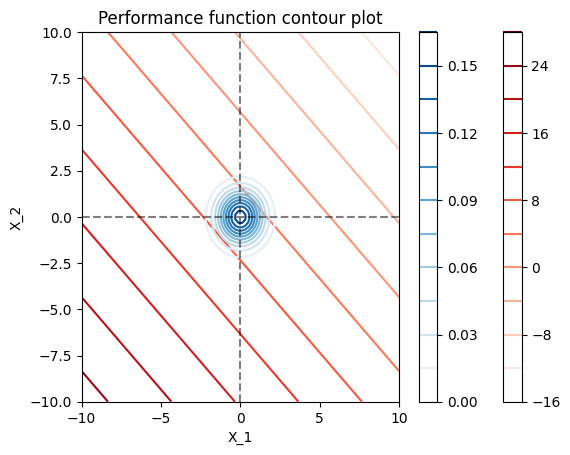

In [4]:
x = torch.linspace(-10, 10, 100)
y = torch.linspace(-10, 10, 100)
X, Y = torch.meshgrid(x, y)
Z = performance_fn([X, Y])
Z_norm = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)).log_prob(torch.stack([X, Y]).T).exp()

plt.contour(X.numpy(), Y.numpy(), Z.numpy(), levels=10, cmap="Reds")
plt.colorbar()
plt.contour(X.numpy(), Y.numpy(), Z_norm.numpy(), levels=10, cmap="Blues")
plt.colorbar()
plt.axhline(y=0, color="k", linestyle="--", alpha=0.5)
plt.axvline(x=0, color="k", linestyle="--", alpha=0.5)
plt.xlabel("X_1")
plt.ylabel("X_2")
plt.title("Performance function contour plot")
plt.show()



In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hamiltonian Monte Carlo
Mofidication to the HMC: new sample ifs accepted only if (performance_fn(new_sample) < c_i)
This is just to make sure that we don't stray too far away from the original direction that we want to move in.

In [6]:
def hamiltonian_monte_carlo(n_samples, negative_log_prob_new, initial_position, path_len, step_size, c):
    # random step size
    if step_size is None:
        step_size = torch.tensor(0.01 + (0.05 - 0.01) * torch.rand(1))

    samples = [initial_position]

    # torch.random.manual_seed(0) # for reproducibility
    # Keep a single object for momentum resampling
    momentum = dist.MultivariateNormal(torch.zeros(initial_position.shape), torch.eye(initial_position.shape[0]))

    # If initial_position is a 2D tensor and n_samples is 100, we want
    # 100 x 2 momentum draws; do one momentum.sample call
    size = (n_samples,) + initial_position.shape[:1]
    count = 0  # to keep track of how many samples we've drawn
    for _ in range(size[0]):
        p0 = momentum.sample() # initial momentum draw
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog( 
            samples[-1],
            p0,
            negative_log_prob_new,
            initial_position,
            path_len=path_len,
            step_size=step_size,
        )
        # Do Metropolis accept/reject step
        start_log_p = (negative_log_prob_new(samples[-1]) - torch.sum(momentum.log_prob(p0))).to(device)
        new_log_p = (negative_log_prob_new(q_new) - torch.sum(momentum.log_prob(p_new))).to(device)
        if (torch.log(torch.rand(size=(1,))) < start_log_p - new_log_p) and (performance_fn(q_new) < c): # log probability difference
            samples.append(q_new) # accept
            count += 1 # for computing accept rate
        else:
            samples.append(samples[-1].clone()) # reject

    return torch.stack(samples[1:], dim=0).to(device)

def leapfrog(q, p, negative_log_prob_new, initial_position, path_len, step_size): # do one leapfrog step
    q, p = q.clone(), p.clone() # copy to avoid mutation

    # Compute the gradient of the negative log probability
    dVdq = torch.autograd.grad(negative_log_prob_new(initial_position), initial_position, create_graph=False)[0]
    p -= step_size * dVdq / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        dVdq = torch.autograd.grad(negative_log_prob_new(q), q, create_graph=False)[0]  # Recompute gradient
        p -= step_size * dVdq  # whole step
    q += step_size * p  # whole step
    dVdq = torch.autograd.grad(negative_log_prob_new(q), q, create_graph=False)[0]  # Recompute gradient
    p -= step_size * dVdq / 2  # half step
    # Momentum flip at end 
    return q, -p

## For the first subset, set the intial log of distribution for HMC
negative log of distribution = -log( N([0,0], \Sigma([[1,0],[0,1]])) )

In [7]:
def initial_subset_log_prob(x):
    return -torch.log(torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2)).log_prob(x).exp()).to(device)

In [8]:
p = 0.1 # intermediate probability function
N = 1000 # number of samples from each subset
nDim  = 2 # number of dimensions
Nc = int(N*p); # number of seeds for the next level
Ns = 10 # number of samples for each MC

In [9]:
# x1 = hamiltonian_monte_carlo(  N, initial_subset_log_prob, torch.zeros(2, requires_grad=True), path_len=5, step_size=0.1, c=10000) # intial samples
# # x1 = torch.randn(N, nDim) # intial samples of first subset
# g1 = performance_fn(x1.T) # performance function at first subset

## Sorting the samples based on the performance function for the first subset

In [10]:
# index, g1_sort = zip(*sorted(enumerate(g1), key=itemgetter(1)))
# g1_sort = torch.Tensor(g1_sort)
# # g1_top = g1_sort[: Nc]
# x1_top = x1[index[: Nc], :]

In [11]:
# L = 1 # number of subsets
# # burn_in = 0
# c = g1_top.max() # setting the threshold for the first subset

In [12]:
def subsim_hmc(performance_fn, p, N, nDim, Nc, Ns):
    # p = 0.1 # intermediate probability function
    # N = 1000 # number of samples from each subset
    # nDim  = 2 # number of dimensions
    # Nc = int(N*p); # number of seeds for the next level
    # Ns = 10 # number of samples for each MC
    x1 = hamiltonian_monte_carlo(  N, initial_subset_log_prob, torch.zeros(2, requires_grad=True), path_len=5, step_size=0.1, c=10000) # intial samples
    g1 = performance_fn(x1.T) # performance function at first subset
    index, g1_sort = zip(*sorted(enumerate(g1), key=itemgetter(1)))
    g1_sort = torch.Tensor(g1_sort)
    g1_top = g1_sort[: Nc]
    x1_top = x1[index[: Nc], :]
    L = 1 # number of subsets
    c = g1_top.max() # setting the threshold for the first subset
    x_new_top = x1_top
    all_subsets_samples = []
    all_subsets_samples.append(x1_top)
    all_c = []
    all_c.append(c)
    while c > 0: # iterate until the threshold is greater than zero
        L = L + 1

        def negative_log_prob_new(x): # define the log probability for the HMC
                # since (performance_function(x) < c) is not differentiable, use sigmoid approximation
                return -torch.log(torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2)).log_prob(x).exp()
                * torch.sigmoid(1*(c - performance_fn(x))).detach())
        
        hmc_samples = []
        for i in range(Nc): # iterate through the seeds on each subset
            seed = x_new_top[i, :].requires_grad_(True) # setting the seed as the initial value for HMC
            hmc_samples.append(hamiltonian_monte_carlo(Ns, negative_log_prob_new, seed, path_len=5, step_size=0.1, c=c))
        hmc_samples = torch.cat(hmc_samples, dim=0) # concatenate the samples from all seeds
        
        print("subset: ", L)

        g_new = performance_fn(hmc_samples.T) # get the performance function for the new subset
        g_new_sort, index = torch.sort(g_new, descending=False) # sort the performance function
        g_new_top = g_new_sort[: Nc] # get the top Nc samples of performance function
        x_new_top = hmc_samples[index[: Nc], :] # get the top Nc samples
        c = g_new_top.max() # set the threshold for the next subset

        all_subsets_samples.append(x_new_top) # save the samples from all subsets
        all_c.append(c) # save the threshold from all subsets
        nf = (g_new_sort < 0).float().sum() # number of failures
    pf = p**(L-1) * nf / N
    print("probability of failure from SubSim: ", pf.item())

    return all_subsets_samples, all_c, pf



In [13]:
all_subsets_samples, all_c, pf = subsim_hmc(performance_fn, p, N, nDim, Nc, Ns)

subset:  2
subset:  3
subset:  4
subset:  5
probability of failure from SubSim:  7.049999840091914e-05


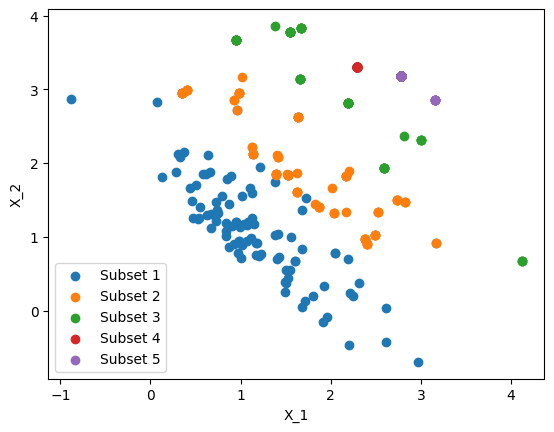

In [14]:
for i in range(len(all_c)):
    subset = all_subsets_samples[i]
    plt.scatter(subset[:, 0].detach().numpy(), subset[:, 1].detach().numpy(), label=f'Subset {i+1}')
plt.xlabel("X_1")
plt.ylabel("X_2")
plt.legend()
plt.show()

# Run multiple SubSim to get an 'average' of probability of failure

In [15]:
all_pf = []
for _ in range(10):
    _, _, pf = subsim_hmc(performance_fn, p=0.1, N=1000, nDim=2, Nc=int(N*p), Ns=10)
    all_pf.append(pf)
all_pf = torch.Tensor(all_pf)
mean_pf = all_pf.mean()
std_pf = all_pf.std()

subset:  2
subset:  3
subset:  4
probability of failure from SubSim:  0.00018200001795776188
subset:  2
subset:  3
subset:  4
subset:  5
probability of failure from SubSim:  1.1000000085914508e-05
subset:  2
subset:  3
subset:  4
probability of failure from SubSim:  0.00023600002168677747
subset:  2
subset:  3
subset:  4
subset:  5
subset:  6
probability of failure from SubSim:  6.86999965182622e-06
subset:  2
subset:  3
subset:  4
subset:  5
probability of failure from SubSim:  1.6399999367422424e-05
subset:  2
subset:  3
subset:  4
probability of failure from SubSim:  0.00038800001493655145
subset:  2
subset:  3
subset:  4
subset:  5
subset:  6
probability of failure from SubSim:  7.79999936639797e-06
subset:  2
subset:  3
subset:  4
subset:  5
subset:  6
probability of failure from SubSim:  8.299999535665847e-06
subset:  2
subset:  3
subset:  4
subset:  5
subset:  6
probability of failure from SubSim:  8.599999091529753e-06
subset:  2
subset:  3
subset:  4
subset:  5
probability of 

In [16]:
print("mean of subsim runs: ", mean_pf.item())
print("std deviation of subsim runs: ", std_pf.item())

mean of subsim runs:  9.182700887322426e-05
std deviation of subsim runs:  0.0001327168138232082


# Histogram of multiple SubSim runs

Text(0, 0.5, 'Frequency')

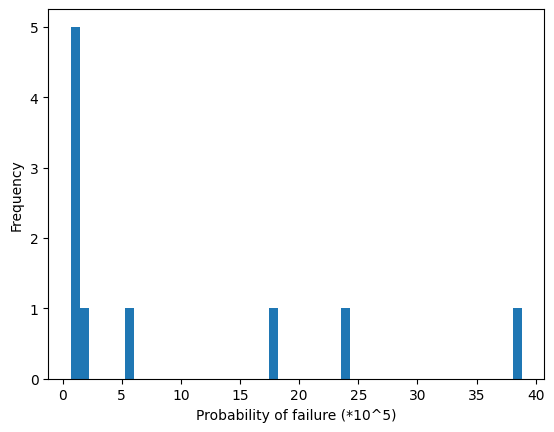

In [25]:
# q25, q75 = np.percentile(all_pf, [25, 75])
# bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
# bins = int(torch.round((all_pf.max() - all_pf.min()) / bin_width))
plt.hist(all_pf*100000, bins=50)
plt.xlabel("Probability of failure (*10^5)")
plt.ylabel("Frequency")

# Monte Carlo Simulation

In [26]:
N=int(1e6) # Number of samples
G=torch.zeros(N,1) # Initialize the performance function evaluations
for i in range (0,N):
    x_mcs=torch.randn(size=(2,1)).to(device) # Generating random numbers
    G[i]=torch.Tensor(performance_fn(x_mcs)).to(device) # Evaluating the performance function
pf_mcs=(G <0).sum()/N # Estimate of the probability of failurepf mcs
print("probability of failure from MCS: ", pf.item())

probability of failure from MCS:  5.329999839887023e-05


# Reliability Index

In [28]:
reliability_index = abs(torch.distributions.Normal(0, 1).icdf(pf))
print("reliability index: ", reliability_index.item())

reliability index:  3.87511944770813
